I noticed that YJNRC21-1 has no allele sharing strains at 70% similarity. Here I will check the code of 01_pixy, which was I think taken from the Shiny app.


# Conclusion

I could not find an issue per se with any of the data. However, the logic behind the similarity calculation is bad. So far, I have been taking the % homozygous similarity at the opposite homozygous loci. This is correlated with the actual similarity, like via IBS, but is not the same thing. First of all, it looks at only a subset of loci, in this case 750ish of 65Kish. I am not sure if IBS is the perfect measure, and what the best cutoff would be, but this seems to be causing the issue. The best course of action would probably be to use IBS and also add a direct Dxy between the two parental strains.

In [44]:
library(tidytable)
library(stringr)
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.1.3"


In [13]:
c<-"YJNRC21"
i<-1 # row trd region
selectSimilarity=0.7

In [6]:
if(!file.exists(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))){
        print("skip1")
        next
    }
    if(file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz")) < file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))){
        print("skip2")
        next
    }
    if(file.mtime(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))<file.mtime(paste0("/home/jnrunge/data/trd/mapped_reads/TRD.vcf.gz"))){
        print("skip3")
        next
    }
    AS=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz.allelesharing.csv.gz"))

    TRD=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
    if(!file.exists(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))){
        print("skip4")
        next
    }

    TRD_loci=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))

In [19]:
TRD_loci

ID,lengthSNPs,chr_start,chr_end,global_start,global_end,lengthBp
<int>,<int>,<chr>,<chr>,<int>,<int>,<int>
1,759,chromosome2,chromosome2,547041,894540,347499
3,322,chromosome12,chromosome12,7864969,7965056,100087


In [8]:
if(TRD_loci$chr_start[i]!=TRD_loci$chr_end[i]){
        stop("chr overlapping TRD")
    }
        TRD_subset=filter(TRD, chr== TRD_loci$chr_start[i] & global_pos >= TRD_loci$global_start[i] & global_pos <= TRD_loci$global_end[i])
        df_AS_filtered=filter(AS, `#CHROM` == TRD_loci$chr_start[i], POS %in% TRD_subset$pos)

In [49]:
head(df_AS_filtered)

#CHROM,POS,AAA,AAB,AAC,AAD,AAE,AAG,AAH,AAI,...,XTRA_FFI,XTRA_FFJ,XTRA_FFK,XTRA_FFL,XTRA_FFM,XTRA_FFN,XTRA_FFO,XTRA_FFP,XTRA_FFQ,chrpos
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chromosome2,340242,A2_hom,A2_hom,A2_hom,A1_hom,A2_hom,A1_hom,A2_hom,A2_hom,...,A2_hom,A1_hom,Other,Other,A2_hom,Other,A2_hom,A2_hom,Other,Other
chromosome2,340737,A2_hom,A2_hom,A2_hom,A1_hom,A2_hom,A2_hom,A2_hom,A2_hom,...,A2_hom,Other,Other,Other,A2_hom,Other,A2_hom,A2_hom,Other,Other
chromosome2,340913,A2_hom,A2_hom,A2_hom,A1_hom,A2_hom,A2_hom,A2_hom,A2_hom,...,A2_hom,Other,Other,Other,A2_hom,Other,Other,Other,Other,Other
chromosome2,341391,A2_hom,A2_hom,Other,A1_hom,A2_hom,A2_hom,A2_hom,A2_hom,...,A2_hom,Other,Other,A2_hom,Other,Other,Other,A2_hom,A2_hom,Other
chromosome2,341451,A2_hom,A2_hom,Other,A1_hom,A2_hom,A2_hom,A2_hom,A2_hom,...,A2_hom,Other,Other,A2_hom,Other,Other,Other,A2_hom,A2_hom,Other
chromosome2,341533,A2_hom,A2_hom,A2_hom,A1_hom,A2_hom,A2_hom,A2_hom,A2_hom,...,A2_hom,Other,A2_hom,A2_hom,A2_hom,A2_hom,A2_hom,A2_hom,A2_hom,Other


In [51]:
f<-"/home/jnrunge/data/TRD/results/shiny/YJNRC21-AF.csv.gz.loci.full.vcf.gz"
vcf=fread(cmd=paste0("zcat ",f," | grep -v ^##"), data.table = FALSE)

vcf<-mutate(vcf,chrpos=paste(`#CHROM`,POS))

df_AS_filtered<-mutate(df_AS_filtered,chrpos=paste(`#CHROM`,POS))


vcf<-filter(vcf, chrpos %in% pull(df_AS_filtered, chrpos))
head(vcf)

#CHROM,POS,ID,REF,ALT...5,QUAL,FILTER,INFO,FORMAT,AAA,...,XTRA_FFI,XTRA_FFJ,XTRA_FFK,XTRA_FFL,XTRA_FFM,XTRA_FFN,XTRA_FFO,XTRA_FFP,XTRA_FFQ,chrpos
<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chromosome2,340242,.,T,C,2456400,.,AC=765;AF=0.154;AN=4978;BaseQRankSum=0.217;DP=382357;ExcessHet=-0;FS=0.568;InbreedingCoeff=0.5443;MLEAC=765;MLEAF=0.154;MQ=60;MQRankSum=0;QD=25.88;ReadPosRankSum=0.089;SOR=0.754,GT:AD:DP:GQ:PL,"0/0:195,0:195:99:0,120,1800",...,"0/0:67,0:67:99:0,120,1800","1/1:0,52:52:99:1813,155,0","0/1:633,660:1293:99:21082,0,19601","0/1:355,376:731:99:12213,0,11018","0/0:913,0:913:99:0,120,1800","0/1:905,337:1242:99:9001,0,30459","0/0:930,0:930:99:0,120,1800","0/0:518,0:518:99:0,120,1800","0/1:773,269:1043:99:7057,0,26245",chromosome2 340242
chromosome2,340737,.,G,A,1865660,.,AC=522;AF=0.105;AN=4978;BaseQRankSum=-0.787;DP=408518;ExcessHet=-0;FS=0.543;InbreedingCoeff=0.4206;MLEAC=522;MLEAF=0.105;MQ=60;MQRankSum=0;QD=23.51;ReadPosRankSum=-0.091;SOR=0.742,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:218,0:218:99:.:.:0,120,1800:.",...,"0/0:71,0:71:99:.:.:0,120,1800:.","0/1:41,21:62:99:.:.:552,0,1141:.","0/1:648,677:1325:99:.:.:21265,0,21048:.","0/1:328,337:665:99:.:.:10992,0,12481:.","0/0:837,0:837:99:.:.:0,120,1800:.","0/1:1005,312:1317:99:.:.:8192,0,34907:.","0/0:948,0:948:99:.:.:0,120,1800:.","0/0:523,0:523:99:.:.:0,120,1800:.","0/1:276,829:1105:99:.:.:28739,0,7617:.",chromosome2 340737
chromosome2,340913,.,T,C,2273830,.,AC=614;AF=0.123;AN=4978;BaseQRankSum=-0.484;DP=387604;ExcessHet=-0;FS=0;InbreedingCoeff=0.5503;MLEAC=614;MLEAF=0.123;MQ=60;MQRankSum=0;QD=27.1;ReadPosRankSum=0.037;SOR=0.647,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:184,0:184:99:.:.:0,120,1800:.",...,"0/0:67,0:67:99:.:.:0,120,1800:.","0/1:43,38:81:99:.:.:1110,0,1372:.","0/1:688,672:1360:99:.:.:23380,0,22665:.","0/1:326,332:658:99:.:.:10720,0,10515:.","0/0:959,0:959:99:.:.:0,120,1800:.","0/1:956,311:1267:99:.:.:10061,0,33011:.","0/1:729,227:956:99:.:.:6248,0,25680:.","0/1:266,263:529:99:.:.:8946,0,9133:.","0/1:250,746:996:99:.:.:29092,0,6700:.",chromosome2 340913
chromosome2,341391,.,T,"A,G",15176400,.,"AC=4381,1;AF=0.88,0.0002009;AN=4978;BaseQRankSum=0.258;DP=442073;ExcessHet=-0;FS=1.169;InbreedingCoeff=0.4612;MLEAC=4384,1;MLEAF=0.881,0.0002009;MQ=60;MQRankSum=0;QD=30.25;ReadPosRankSum=-0.047;SOR=0.648",GT:AD:DP:GQ:PGT:PID:PL:PS,"1/1:0,249,0:249:99:.:.:10467,749,0,10467,749,10467:.",...,"1/1:0,82,0:82:99:.:.:2940,245,0,2940,245,2940:.","0/1:26,35,0:61:99:.:.:1040,0,667,1117,773,1890:.","0/1:336,975,0:1311:99:.:.:33122,0,8718,34128,11643,45770:.","1|1:1,775,0:776:99:1|1:341309_A_G:33548,2288,0,33551,2330,33593:341309","0/1:252,743,0:995:99:.:.:25604,0,6494,26359,8723,35082:.","0/1:611,632,1:1244:99:.:.:20477,0,19928,22581,22187,48423:.","0/1:475,542,2:1019:99:.:.:17661,0,14889,19074,16469,35655:.","1|1:1,513,0:514:99:1|1:341391_T_A:22482,1501,0,22485,1543,22527:341391","1/1:0,1006,0:1006:99:.:.:44530,3027,0,44530,3027,44530:.",chromosome2 341391
chromosome2,341451,.,A,G,15009300,.,AC=4369;AF=0.878;AN=4978;BaseQRankSum=0.44;DP=441976;ExcessHet=-0;FS=0;InbreedingCoeff=0.4673;MLEAC=4376;MLEAF=0.879;MQ=60;MQRankSum=0;QD=31.97;ReadPosRankSum=0.115;SOR=0.721,GT:AD:DP:GQ:PGT:PID:PL:PS,"1/1:0,251:251:99:.:.:10130,752,0:.",...,"1/1:0,90:90:99:.:.:2893,264,0:.","0/1:21,29:50:99:.:.:816,0,592:.","0/1:334,986:1320:99:.:.:33202,0,8627:.","1|1:2,750:752:99:1|1:341309_A_G:31591,2170,0:341309","0/1:229,740:969:99:.:.:25489,0,5721:.","0/1:615,628:1243:99:.:.:19834,0,19831:.","0/1:474,559:1033:99:.:.:18033,0,14813:.","1|1:0,486:486:99:1|1:341391_T_A:20697,1461,0:341391","1/1:0,1052:1052:99:.:.:44165,3163,0:.",chromosome2 341451
chromosome2,341533,.,A,G,1694760,.,AC=550;AF=0.111;AN=4976;BaseQRankSum=0.127;DP=382977;ExcessHet=-0;FS=0;InbreedingCoeff=0.4754;MLEAC=551;MLEAF=0.111;MQ=60;MQRankSum=0;QD=24.69;ReadPosRankSum=-0.019;SOR=0.666,GT:AD:DP:GQ:PGT:PID:PL:PS,"0/0:198,0:198:99:.:.:0,120,1800:.",...,"0/0:64,0:64:99:.:.:0

In [53]:
df<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
df<-filter(df, paste(chr, pos) %in% pull(df_AS_filtered, chrpos))
head(df)

chr,pos,alleles,GT1,GT2,ADcross,DPcross,AD3_0,AD3_1,AD3_2,AD3_3,Allele1,Allele2,AD_A1,AD_A2,global_pos,sumCount,smoothed,lwr,upr
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
chromosome2,340242,"T,C",1/1,0/0,"58,88",146,58,88,NA,NA,1,0,88,58,547041,146,0.5998686,0.5861552,0.6135821
chromosome2,340737,"G,A",1/1,0/0,"39,68",107,39,68,NA,NA,1,0,68,39,547536,107,0.6001430,0.5863262,0.6139599
chromosome2,340913,"T,C",1/1,0/0,"47,76",123,47,76,NA,NA,1,0,76,47,547712,123,0.6002395,0.5863826,0.6140964
chromosome2,341391,"T,A",0/0,1/1,"71,40",111,71,40,NA,NA,0,1,71,40,548190,111,0.6005003,0.5865275,0.6144732
chromosome2,341451,"A,G",0/0,1/1,"79,38",117,79,38,NA,NA,0,1,79,38,548250,117,0.6005330,0.5865451,0.6145210
chromosome2,341533,"A,G",1/1,0/0,"43,86",129,43,86,NA,NA,1,0,86,43,548332,129,0.6005778,0.5865690,0.6145867


In [63]:
ReCalcSimilarity=function(i){
    GTs<-select(vcf,i)%>%pull()
    GTs<-substr(GTs, 1,3)

    sample=colnames(select(vcf,i))

    if(nrow(df)==nrow(vcf)){
        similarity=sum(GTs==pull(df,GT1))/nrow(vcf)
        return(data.table(s=sample,simFocal1=similarity))
    }
}

similarity_done_again=bind_rows(lapply(10:ncol(vcf),
                               ReCalcSimilarity))

similarity_done_again

s,simFocal1
<chr>,<dbl>
AAA,0.1409750
AAB,0.2239789
AAC,0.2015810
AAD,0.4980237
AAE,0.1370224
AAG,0.4769433
AAH,0.3741765
AAI,0.1317523
AAK,0.1343874


In [65]:
similarity_done_again%>%arrange(-simFocal1)%>%head()

s,simFocal1
<chr>,<dbl>
AAM,1.0000000
AFF,0.5994730
XTRA_EJZ,0.5322793
XTRA_ETR,0.5164690
XTRA_DJU,0.5151515
XTRA_ETH,0.5151515


In [10]:
melted=reshape2::melt(df_AS_filtered, id.vars = c("#CHROM","POS"))
        melted=filter(melted, variable != "chrpos")

In [14]:
tmp=summarise(group_by(melted, variable), nAll=n())
        vcf_translated_summary=left_join(tmp,summarise(group_by(melted, variable, value), n=n()), by=c("variable"))%>%mutate(p=n/nAll)%>%select(variable,value,p)%>%rename(Strain=variable, Type=value)
        A1s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A1_hom" & vcf_translated_summary$p>=selectSimilarity]
        A2s=vcf_translated_summary$Strain[vcf_translated_summary$Type=="A2_hom" & vcf_translated_summary$p>=selectSimilarity]

In [48]:
vcf_translated_summary%>%filter(Type=="A1_hom")%>%arrange(-p)

Strain,Type,p
<fct>,<chr>,<dbl>
AAM,A1_hom,0.9934124
AFF,A1_hom,0.6007905
XTRA_EJZ,A1_hom,0.5322793
XTRA_ETR,A1_hom,0.5217391
XTRA_ETH,A1_hom,0.5204216
XTRA_ETQ,A1_hom,0.5191041
XTRA_DJU,A1_hom,0.5164690
XTRA_FCA,A1_hom,0.5151515
CMI,A1_hom,0.5098814


thats fine, but why does the region appear pretty normal in the PCA? let's do that here.

In [20]:
# code from 02_Local-Ph...

library(SNPRelate)
library(ape)

# Get paths of input files
my.vcf <- "/home/jnrunge/data/trd/full2489Matrix.vcf.gz"
subset_samples = "none"

if(subset_samples == "none"){
    subset_samples=NULL
    prefix <- basename(my.vcf)
    }else{
    prefix <- basename(subset_samples)
    subset_samples=readLines(subset_samples)
    }

setwd(dirname(my.vcf))
if(!file.exists(paste0(prefix, ".gds"))){
    snpgdsVCF2GDS(my.vcf, paste0(prefix, ".gds"), ignore.chr.prefix="chromosome")
}

genofile <- snpgdsOpen(paste0(prefix, ".gds"))

Warning message:
"package 'SNPRelate' was built under R version 4.1.3"
Loading required package: gdsfmt

Warning message:
"package 'gdsfmt' was built under R version 4.1.3"
SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)

Warning message:
"package 'ape' was built under R version 4.1.3"

Attaching package: 'ape'


The following object is masked from 'package:tidytable':

    where




In [28]:
TRD_loci=fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-TRD_regions.csv.gz"))

AF<-fread(paste0("/home/jnrunge/data/TRD/results/shiny/",c,"-AF.csv.gz"))
    
tmp_TRD_regions<-left_join(TRD_loci%>%rename(chr=chr_start), select(AF, chr,pos,global_pos)%>%
          rename(global_start=global_pos), by=c("chr","global_start"))%>%rename(start=pos)

TRD_loci<-tmp_TRD_regions

TRD_loci<-mutate(TRD_loci, end=global_end-(global_start-start))

TRD_loci

ID,lengthSNPs,chr,chr_end,global_start,global_end,lengthBp,start,end
<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
1,759,chromosome2,chromosome2,547041,894540,347499,340242,687741
3,322,chromosome12,chromosome12,7864969,7965056,100087,735713,835800


In [29]:
TRD_loci<-slice(TRD_loci, i)

In [32]:
snpset=which(read.gdsn(index.gdsn(genofile, "snp.position"))>=pull(TRD_loci,start)&
                     read.gdsn(index.gdsn(genofile, "snp.position"))<=pull(TRD_loci,end)&
                     read.gdsn(index.gdsn(genofile, "snp.chromosome"))==pull(TRD_loci,chr)%>%str_replace("chromosome",""))
    if(length(snpset)==0){
        next
    }

    pca_trd <- snpgdsPCA(genofile, num.thread=1, snp.id = snpset)

        x_pca_trd<-pca_trd$eigenvect[,1]
        y_pca_trd<-pca_trd$eigenvect[,2]

Principal Component Analysis (PCA) on genotypes:
Excluding 2,150,257 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 65,943
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 320589666
CPU capabilities: Double-Precision SSE2
Thu Sep 21 09:55:41 2023    (internal increment: 2616)
[==================================================] 100%, completed, 1.4m
Thu Sep 21 09:57:05 2023    Begin (eigenvalues and eigenvectors)
Thu Sep 21 09:57:15 2023    Done.


In [34]:
ibs_trd <- snpgdsIBS(genofile, num.thread=1, snp.id = snpset)
        loc <- cmdscale(1 - ibs_trd$ibs, k = 2)

        x_ibs_trd <- loc[, 1]
        y_ibs_trd <- loc[, 2]


Identity-By-State (IBS) analysis on genotypes:
Excluding 2,150,257 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 2,489
    # of SNPs: 65,943
    using 1 thread
IBS:    the sum of all selected genotypes (0,1,2) = 320589666
Thu Sep 21 09:59:38 2023    (internal increment: 65536)
[==================================================] 100%, completed, 33s 
Thu Sep 21 10:00:11 2023    Done.


In [38]:
id<-which(read.gdsn(index.gdsn(genofile, "sample.id"))=="AAM")
id

[1] 11

In [70]:
sum(ibs_trd$ibs[id,]>=0.985)

[1] 48

Strain,Type,p,IBSwFocal
<fct>,<chr>,<dbl>,<dbl>
AAM,A1_hom,0.9934124,1.0000000
AFF,A1_hom,0.6007905,0.9898549
XTRA_EJZ,A1_hom,0.5322793,0.9832810
XTRA_ETR,A1_hom,0.5217391,0.9828640
XTRA_ETH,A1_hom,0.5204216,0.9837435
XTRA_ETQ,A1_hom,0.5191041,0.9819314


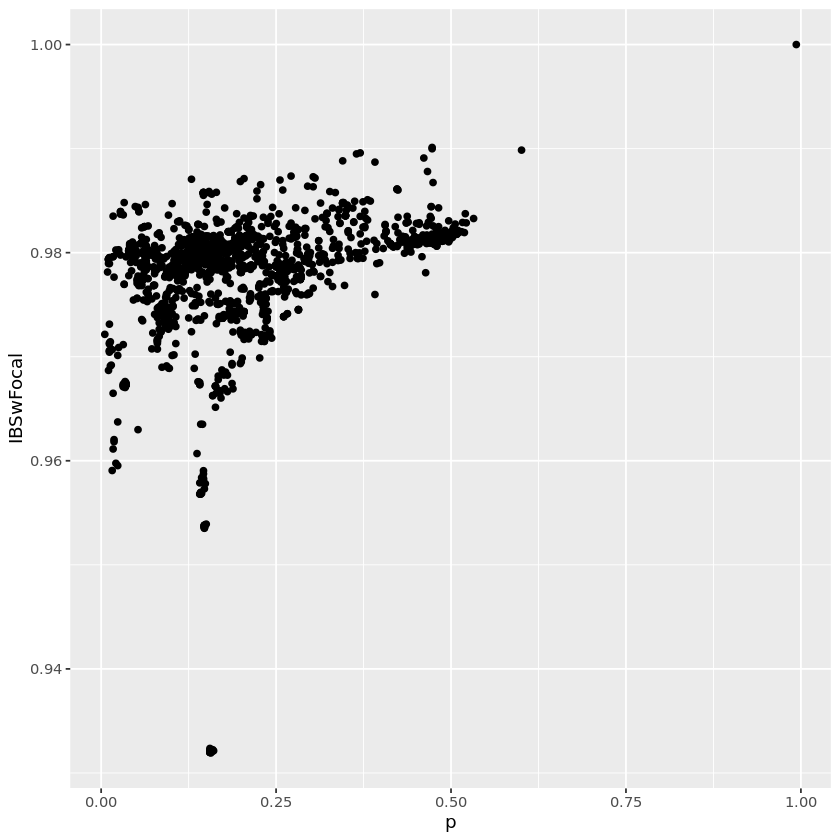

In [45]:
similarity_hom_calc<-vcf_translated_summary%>%filter(Type=="A1_hom")%>%arrange(-p)

getIBS<-function(x){
    # x = Strain
    return(ibs_trd$ibs[id,which(read.gdsn(index.gdsn(genofile, "sample.id"))==x)])
}

similarity_hom_calc<-mutate(similarity_hom_calc, IBSwFocal=unlist(lapply(Strain, getIBS)))

head(similarity_hom_calc)

ggplot(similarity_hom_calc, aes(p,IBSwFocal))+
geom_point()

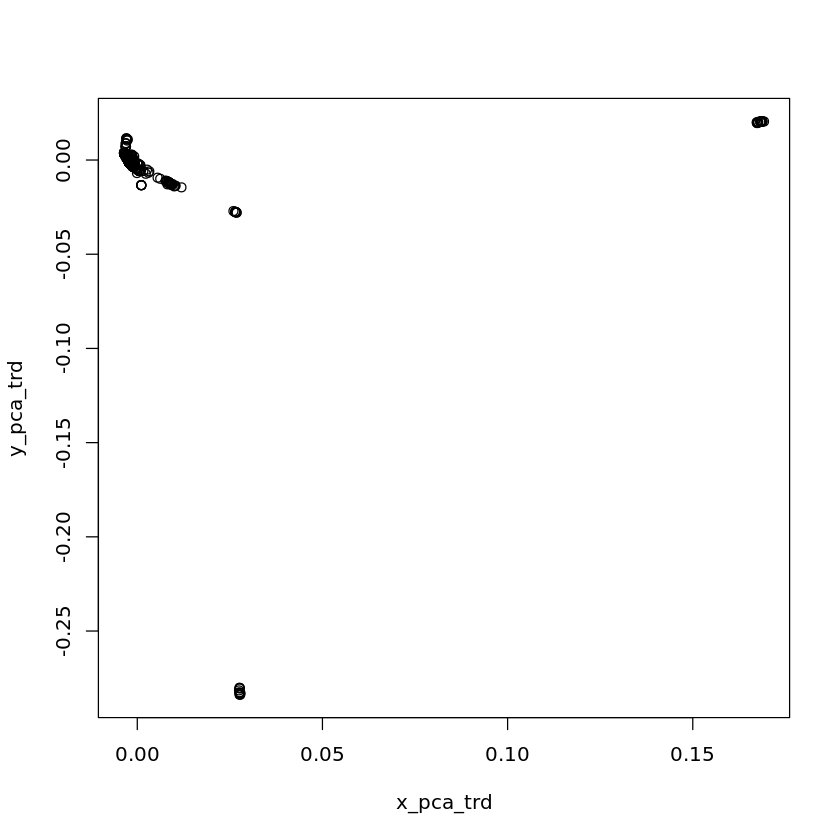

In [33]:
plot(x_pca_trd, y_pca_trd)